In [36]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd 
import numpy as np  
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import words
import re
import language_tool_python
from collections import Counter
from PIL import Image
from textblob import TextBlob
import cufflinks as cf
import plotly.express as px
import plotly.figure_factory as ff
# import torch
# from transformers import PegasusForConditionalGeneration, PegasusTokenizer
# from transformers import T5Tokenizer, T5ForConditionalGeneration
# from transformers import GPT2Tokenizer, GPT2LMHeadModel
from wordcloud import WordCloud,STOPWORDS
from nltk.corpus import stopwords
from plotly import graph_objs as go
from collections import defaultdict
import pandas as pd
from plotly import tools
from plotly.offline import iplot
from palettable.colorbrewer.qualitative import Pastel1_7



In [37]:
from Preprocess.data_cleaning import DataCleaning
from Preprocess.data_visualisation import Data_visualisation



## 1. Data exploration

In [38]:
df = pd.read_csv('C:/Users/iyadh/Desktop/hate_speech/Data/Ethos_Dataset_Binary.csv', sep=';')


In [39]:
df.head(4)

comment  isHate
0          You should know women's sports are a joke     1.0
1    You look like Sloth with deeper Down’s syndrome     1.0
2  You look like Russian and speak like Indian. B...     1.0
3               Women deserve to be abused, I guess.     1.0

In [40]:
df.shape

(998, 2)

In [41]:
df.columns

Index(['comment', 'isHate'], dtype='object')

In [42]:
df= df.rename(columns={'isHate': 'class'})

In [43]:
# Check class value counts (1 hate true , 2 neutral ,0 non hate)
#Were going to work with 1 and 0
df['class'].value_counts()

class
0.000000    354
1.000000    163
0.166667    106
0.833333    100
0.333333     80
0.500000     74
0.666667     70
0.250000      6
0.750000      6
0.857143      3
0.903846      2
0.400000      2
0.018868      2
0.966667      1
0.954545      1
0.973333      1
0.978261      1
0.983871      1
0.983607      1
0.945455      1
0.937500      1
0.678571      1
0.821429      1
0.603448      1
0.722222      1
0.846154      1
0.849057      1
0.296875      1
0.302326      1
0.530612      1
0.200000      1
0.111111      1
0.103448      1
0.160714      1
0.152542      1
0.038961      1
0.090909      1
0.037736      1
0.031746      1
0.029851      1
0.030303      1
0.026316      1
0.016393      1
Name: count, dtype: int64

In [44]:
#Apply clean_class_column  
df = DataCleaning.clean_class_column(df, 'class')


In [45]:
# Display clean_class_column result
df['class'].value_counts()

class
0                 565
1                 358
not considered     75
Name: count, dtype: int64

In [46]:
df

comment class
0            You should know women's sports are a joke     1
1      You look like Sloth with deeper Down’s syndrome     1
2    You look like Russian and speak like Indian. B...     1
3                 Women deserve to be abused, I guess.     1
4    Women are made for making babies and cooking d...     1
..                                                 ...   ...
993   From the midnight sun where the hot springs blow     0
994                        Don't say I'm not your type     0
995   And therefore never send to know for whom the...     0
996                      And I can't stand another day     0
997   All values, unless otherwise stated, are in U...     0

[998 rows x 2 columns]

In [47]:
df.shape

(998, 2)

In [48]:
df = df[df['class'].isin([0, 1])]


In [49]:
# Nombre de valeurs NaN dans la colonne 'comment'
nan_number = df['comment'].isna().sum()
print("Number of NaN values in the column 'comment' :", nan_number)

Number of NaN values in the column 'comment' : 0


In [50]:
df["class"].value_counts(normalize=True)

class
0    0.612134
1    0.387866
Name: proportion, dtype: float64

#####  On remarque que la class target is unbalanced so we must first treat this problem 
##### Also our data isn't that mush 998 so we must generate data
#####  TO adress this problem were going to use : 
 - use T5 model
 - use PEGASUS paraphraser model 
 - use GPT-2 model 
 - synonym replacement, random insertion, and random deletion
 - use smote before training (when splitting data)


##### But before generating new data we're gonna clean the data so that we can generate descent data (a common citation : garbage in garbage out)

In [51]:
# df.to_csv('./Data/hate_speech_merged_data.csv', index=False)

## 2. Data Perprocessing

##### Before generating new data we're going to preprocess our data

In [52]:
# Run this 
# Download the words corpus if not already downloaded
try:
    nltk.data.find('corpora/words')
except LookupError:
    nltk.download('words')

In [96]:
# Sample text to demonstrate each function
sample_text = " @user_name  Hello! 😊 Check     this out: http://example.com wont <p>This is a paragraph.</p> #example <i>Italic</i> &gt; 123abc [remove this]"

# Applying each function and printing the result
print("Original Text:", sample_text)
print("\nAfter removing links:", DataCleaning.remove_links(sample_text))
print("\nAfter removing special characters:", DataCleaning.remove_special_chars(sample_text))
print("\nAfter removing emojis:", DataCleaning.remove_emojis(sample_text))
print("\nAfter removing square brackets:", DataCleaning.remove_square_brackets(sample_text))
print("\nAfter removing hashtags:", DataCleaning.remove_hashtags(sample_text))
print("\nAfter removing spaces and newlines:", DataCleaning.remove_spaces_and_newlines(sample_text))
print("\nAfter removing words with numbers:", DataCleaning.remove_words_with_numbers(sample_text))
print("\nAfter removing HTML tags:", DataCleaning.remove_html_tags(sample_text))
print("\nAfter removing HTML entities:", DataCleaning.remove_html_entities(sample_text))
print("\nAfter removing specific tags:", DataCleaning.remove_specific_tags(sample_text))
print("\nAfter removing puunctuations:", DataCleaning.remove_punctuation(sample_text))
print("\nAfter removing spaces (example this     out):", DataCleaning.remove_unnecessary_spaces(sample_text))
print("\nAfter correcting abbreviations Ex wont : will not:", DataCleaning.expand_abbreviations(sample_text))
print("\nAfter removing users (@user_name : because we have some tweets in our data):", DataCleaning.remove_user_mentions(sample_text))

Original Text: women deserve to be abused, I guess.

After removing links: women deserve to be abused, I guess.

After removing special characters: women deserve to be abused I guess

After removing emojis: women deserve to be abused, I guess.

After removing square brackets: women deserve to be abused, I guess.

After removing hashtags: women deserve to be abused, I guess.

After removing spaces and newlines: women deserve to be abused, I guess.

After removing words with numbers: women deserve to be abused, I guess.

After removing HTML tags: women deserve to be abused, I guess.

After removing HTML entities: women deserve to be abused, I guess.

After removing specific tags: women deserve to be abused, I guess.

After removing puunctuations: women deserve to be abused  I guess 

After removing spaces (example this     out): women deserve to be abused, I guess.

After correcting abbreviations Ex wont : will not: women deserve to be abused, I guess.

After removing users (@user_name :

### Test detect out of vocabulary words 

In [54]:
# Test detect out of vocabulary words 
test_texts = [
        "Hello world rt",
        "Supercalifragilisticexpialidocious is a fantabulous word",
        "I like to program in Python and xzqwk",
    ]
    
for text in test_texts:
    result = DataCleaning.display_oov_words(text)
    print('Original text :',text )
    print(f"OOV words: {result['oov_words']}")
    print(f"Number of OOV words: {result['oov_count']}")
    print('\n')


Original text : Hello world rt
OOV words: ['rt']
Number of OOV words: 1


Original text : Supercalifragilisticexpialidocious is a fantabulous word
OOV words: ['supercalifragilisticexpialidocious', 'fantabulous']
Number of OOV words: 2


Original text : I like to program in Python and xzqwk
OOV words: ['xzqwk']
Number of OOV words: 1




### Test Grammatical errors corrections

In [95]:
# Grammatical errors corrections

tool = language_tool_python.LanguageTool('en-US', remote_server='https://api.languagetool.org')

test_texts = [
        "She go to school everyday but forget her books",
        "He dont likes to plays with they",
        "The cats was chaseing mouses in the yard",
        "I seen him yesterday and he look tired",
        "This are a beautifull day for picnic",
        'women deserve to be abused, I guess.'
    ]
    
for text in test_texts:
    corrected = DataCleaning.correct_grammar(text)
    print(f"\nOriginal: {text}")
    print(f"Grammar corrected: {corrected}")
    
    # Close the language tool when done
    tool.close()


Original: She go to school everyday but forget her books
Grammar corrected: She goes to school every day but forget her books

Original: He dont likes to plays with they
Grammar corrected: He don't likes to plays with them

Original: The cats was chaseing mouses in the yard
Grammar corrected: The cats were chasing mouses in the yard

Original: I seen him yesterday and he look tired
Grammar corrected: I have seen him yesterday and he looks tired

Original: This are a beautifull day for picnic
Grammar corrected: These is a beautiful day for picnic

Original: women deserve to be abused, I guess.
Grammar corrected: Women deserve to be abused, I guess.


##### We have defined preprocess_text functiouns that does all the step above and werre going to call it 

In [56]:
# df['cleaned_comment'] = df['comment'].apply(DataCleaning.preprocess_text)

In [57]:
# Apply the function with progress tracking
df['cleaned_comment'] = [DataCleaning.track_progress(row['comment'], i) for i, row in df.iterrows()]

Processing row 0
Processing row 1
Processing row 2
Processing row 3
Processing row 4
Processing row 5
Processing row 6
Processing row 7
Processing row 8
Processing row 9
Processing row 10
Processing row 11
Processing row 12
Processing row 13
Processing row 14
Processing row 15
Processing row 16
Processing row 17
Processing row 18
Processing row 19
Processing row 20
Processing row 21
Processing row 22
Processing row 23
Processing row 24
Processing row 25
Processing row 26
Processing row 27
Processing row 28
Processing row 29
Processing row 30
Processing row 31
Processing row 32
Processing row 33
Processing row 34
Processing row 35
Processing row 36
Processing row 37
Processing row 38
Processing row 39
Processing row 40
Processing row 41
Processing row 42
Processing row 43
Processing row 44
Processing row 45
Processing row 46
Processing row 47
Processing row 48
Processing row 49
Processing row 50
Processing row 51
Processing row 52
Processing row 53
Processing row 54
Processing row 55
Pr

In [58]:
df.head(4)

comment class  \
0          You should know women's sports are a joke     1   
1    You look like Sloth with deeper Down’s syndrome     1   
2  You look like Russian and speak like Indian. B...     1   
3               Women deserve to be abused, I guess.     1   

                                     cleaned_comment  
0                  You should know sports are a joke  
1                  You look like sloth with syndrome  
2  You look like and speak like both are disgusti...  
3                              Deserve to be I guess

In [59]:
df.to_csv('./Data/hate_speech_preprocessed_data.csv', index=False)

## DataCleaning Class Steps

### 1. Initialization
- **Imports** : `re`, `pandas`, `string`, `nltk`, `language_tool_python`
- **NLTK Corpus**: Downloads `words` corpus if not present
- **Language Tool**: Initializes with remote server `https://api.languagetool.org`
- **Abbreviations**: Defines a dictionary of common abbreviations

### 2. Text Cleaning Methods

#### remove_links
- **Action**: Removes URLs (http/www)
- **Regex**: `r'http\S+|www\S+'`

#### remove_user_mentions
- **Action**: Removes @mentions
- **Regex**: `r'@\w+'`

#### remove_html_tags
- **Action**: Removes HTML tags
- **Regex**: `r'<.*?>+'`

#### remove_html_entities
- **Action**: Cleans HTML entities (>, ', /)
- **Regex**: Multiple `re.sub` calls

#### remove_specific_tags
- **Action**: Removes specific tags  
- **Regex**: Tag-specific patterns

#### remove_special_chars
- **Action**: Removes special characters
- **Regex**: `r'[^\w\s]'`

#### remove_emojis
- **Action**: Removes Unicode emojis
- **Regex**: Emoji range pattern

#### remove_square_brackets
- **Action**: Removes text in square brackets
- **Regex**: `r'\[.*?\]'`

#### remove_hashtags
- **Action**: Removes hashtags
- **Regex**: `r'#\w+'`

#### remove_spaces_and_newlines
- **Action**: Removes tabs and newlines
- **Method**: `replace("\t", "").replace("\n", "")`

#### remove_words_with_numbers
- **Action**: Removes words with digits
- **Regex**: `r'\w*\d\w*'`

#### remove_punctuation
- **Action**: Replaces punctuation with spaces
- **Method**: `translate` with `string.punctuation`

#### remove_unnecessary_spaces
- **Action**: Normalizes multiple spaces to single
- **Regex**: `r'\s+'`

#### expand_abbreviations
- **Action**: Expands abbreviations using dictionary
- **Method**: List comprehension with `ABBREVIATIONS`

#### correct_grammar
- **Action**: Corrects grammar
- **Tool**: `language_tool_python`
- **Fallback**: Returns original text on error

#### detect_oov_words
- **Action**: Removes OOV words
- **Uses**: NLTK `words` corpus
- **Returns**: Cleaned text

### 3. Main Preprocessing Pipeline (preprocess_text)
1. Convert to lowercase
2. Remove links
3. Remove user mentions
4. Remove HTML tags
5. Remove HTML entities
6. Remove specific tags
7. Remove special characters
8. Remove emojis
9. Remove square brackets
10. Remove hashtags
11. Expand abbreviations
12. Remove spaces/newlines
13. Remove words with numbers
14. Remove punctuation
15. Remove OOV words
16. Grammar correction
17. Remove unnecessary spaces 


## 3. Data augmentation

### This code is just an explanation since we don't have cuda we're going to run the code on cloab and the notebooks will be uploaded to colab_notebooks folder

In [60]:

# model_name = "t5-large"  # Or "t5-base" or "t5-large"
# tokenizer = T5Tokenizer.from_pretrained(model_name)
# model = T5ForConditionalGeneration.from_pretrained(model_name)

In [61]:
# def paraphrase_text(text, num_return_sequences=3):
#     input_text = f"Rephrase this text: {text.lower()}"  # Convert the input text to lowercase
#     inputs = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True)
#     outputs = model.generate(
#         inputs["input_ids"],
#         max_length=20,
#         num_return_sequences=num_return_sequences,  # Generate multiple paraphrases
#         do_sample=True,  # Enable sampling for diversity
#         top_k=50,
#         top_p=0.95,
#         no_repeat_ngram_size=2  # Prevents repeating 2-word sequences
#     )
#     paraphrases = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]
    
#     # Convert the paraphrases to lowercase and remove the lowercase version of the prompt
#     paraphrases = [paraphrase.replace("rephrase", "").strip().lower() for paraphrase in paraphrases]
    
#     return paraphrases



In [62]:
# # Test 
# sample_text = "white people are shit human beings"
# paraphrases = paraphrase_text(sample_text)
# # print(f"Original: {sample_text}")
# # print(f"Paraphrases: {paraphrases}")

In [63]:
# # Test 
# sample_text = "white people are shit human beings"
# paraphrases = paraphrase_text(sample_text)
# # print(f"Original: {sample_text}")
# # print(f"Paraphrases: {paraphrases}")

In [64]:
# print(f"Paraphrases: {paraphrases}")

In [65]:
# # peagsus paraphraser generation function
# model_name = 'tuner007/pegasus_paraphrase'
# torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'
# tokenizer = PegasusTokenizer.from_pretrained(model_name)
# model = PegasusForConditionalGeneration.from_pretrained(model_name).to(torch_device)

# def get_response(input_text,num_return_sequences,num_beams):
#   batch = tokenizer([input_text],truncation=True,padding='longest',max_length=60, return_tensors="pt").to(torch_device)
#   translated = model.generate(**batch,max_length=60,num_beams=num_beams, num_return_sequences=num_return_sequences, temperature=1.5)
#   tgt_text = tokenizer.batch_decode(translated, skip_special_tokens=True)
#   return tgt_text

In [66]:
# num_beams = 10
# num_return_sequences = 10

In [67]:
# response=get_response("white people are shit human beings",num_return_sequences,num_beams)
# response

In [68]:
# #Another example
# response=get_response("i love this movie",num_return_sequences,num_beams)
# response

In [69]:
# augmented_data = []
# for text in minority_data:
#     paraphrases = paraphrase_text(text, num_return_sequences=2)  # Generate 2 new samples per original
#     augmented_data.extend([(para, minority_class) for para in paraphrases])

# # Convert to dataframe
# augmented_df = pd.DataFrame(augmented_data, columns=['comment', 'label'])

In [70]:

# tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
# model = GPT2LMHeadModel.from_pretrained("gpt2")

# def generate_text(text, max_length=20, num_samples=5):
#     prompt = f"Parphrase this text: {text}"  # Clearer phrasing for paraphrasing
#     inputs = tokenizer(prompt, return_tensors="pt")
    
#     # Generate multiple samples
#     outputs = model.generate(inputs["input_ids"], max_length=max_length, do_sample=True, top_k=50, num_return_sequences=num_samples)
    
#     # Decode and return all the generated samples
#     return [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]

# # Example usage
# text = "i love you"
# generated_samples = generate_text(text)

# # Print all generated samples
# for i, sample in enumerate(generated_samples, 1):
#     print(f"Sample {i}: {sample}")


##### As we can see the models are generating some decent data especially Pegasus so we're going to mainly focus on data generated from Pegasus
##### Since we dont have cuda were going to run in colab and u can find the notebooks in folder colab notebooks


# 4. Data visulaisation

In [71]:
df.describe()

comment  class  \
count                                                 923    923   
unique                                                923      2   
top      All values, unless otherwise stated, are in U...      0   
freq                                                    1    565   

                                         cleaned_comment  
count                                                923  
unique                                               920  
top     I am very sad about this situation with all this  
freq                                                   2

In [72]:
# Display number of comments
visualizer = Data_visualisation(df) 
styled_df = visualizer.visualize_class_counts()
styled_df  

In [73]:
visualizer.visualize_funnel_chart()

In [74]:
# nltk.download('stopwords')

In [75]:
# Display common words count
styled_words = visualizer.visualize_top_words()
styled_words  

In [76]:
# Display the bar chart for common words in all data
visualizer.visualize_word_bar_chart()  

In [77]:
visualizer.visualize_word_treemap()

## Common words for hate speech

In [78]:
styled_hate_words = visualizer.visualize_hate_speech_words()
styled_hate_words  # Display the styled DataFrame for hate speech words

In [79]:
visualizer.visualize_hate_speech_treemap()  # Display the treemap for hate speech words

# Common words for non hate speech

In [80]:
styled_non_hate_words = visualizer.visualize_non_hate_speech_words()
styled_non_hate_words  # Display the styled DataFrame for non-hate speech words

In [81]:
visualizer.visualize_non_hate_speech_treemap()  # Display the treemap for non-hate speech words

In [82]:
visualizer.visualize_hate_non_hate_bar_charts()  # Display the dual bar chart

In [83]:
visualizer.visualize_hate_non_hate_bigram_bar_charts() # Display the bigram bar charts

In [84]:
visualizer.visualize_hate_non_hate_trigram_bar_charts() # Display the trigram bar charts

In [85]:
unique_positive = visualizer.words_unique(0, 20)  # Non-hate speech
unique_negative = visualizer.words_unique(1, 20)  # Hate speech

In [86]:
print("The top 20 unique words in Non Hate Speech are:")
unique_positive.style.background_gradient(cmap='Greens')

The top 20 unique words in Non Hate Speech are:


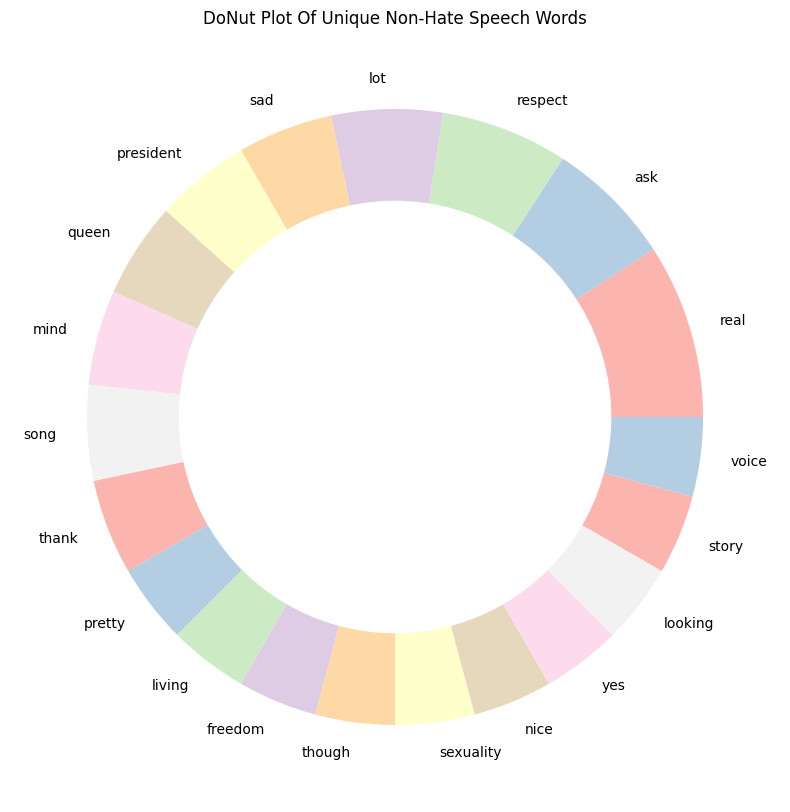

In [87]:
# For non-hate speech
visualizer.visualize_unique_words_donut(0, 20, colors=plt.cm.Pastel1.colors)

In [88]:
print("The top 20 unique words in Hate Speech are:")
unique_negative.style.background_gradient(cmap='Greens')

The top 20 unique words in Hate Speech are:


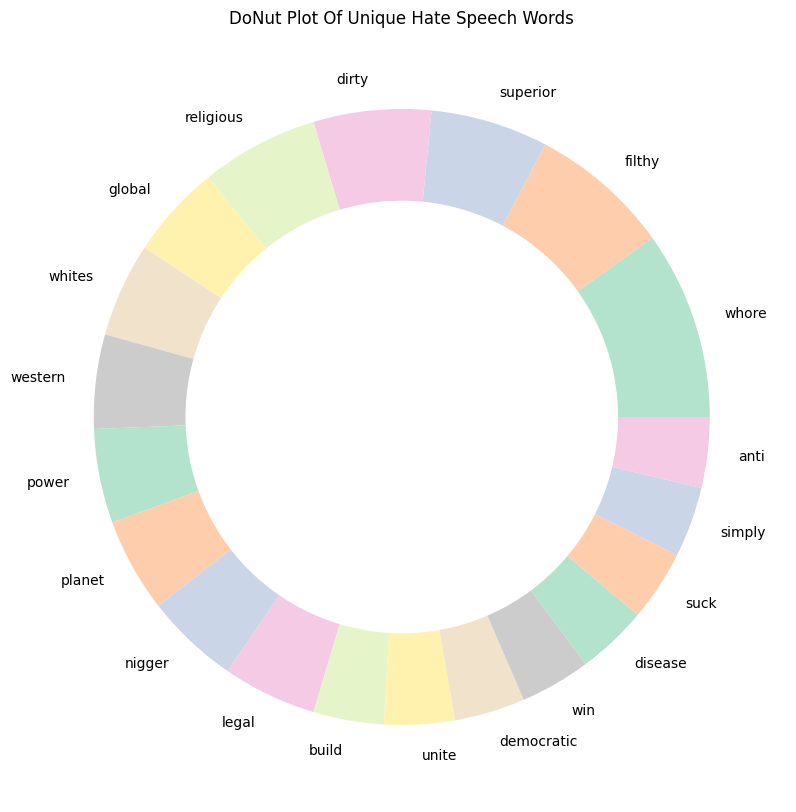

In [89]:
# For hate speech
visualizer.visualize_unique_words_donut(1, 20, colors=plt.cm.Pastel2.colors)

## Word count 

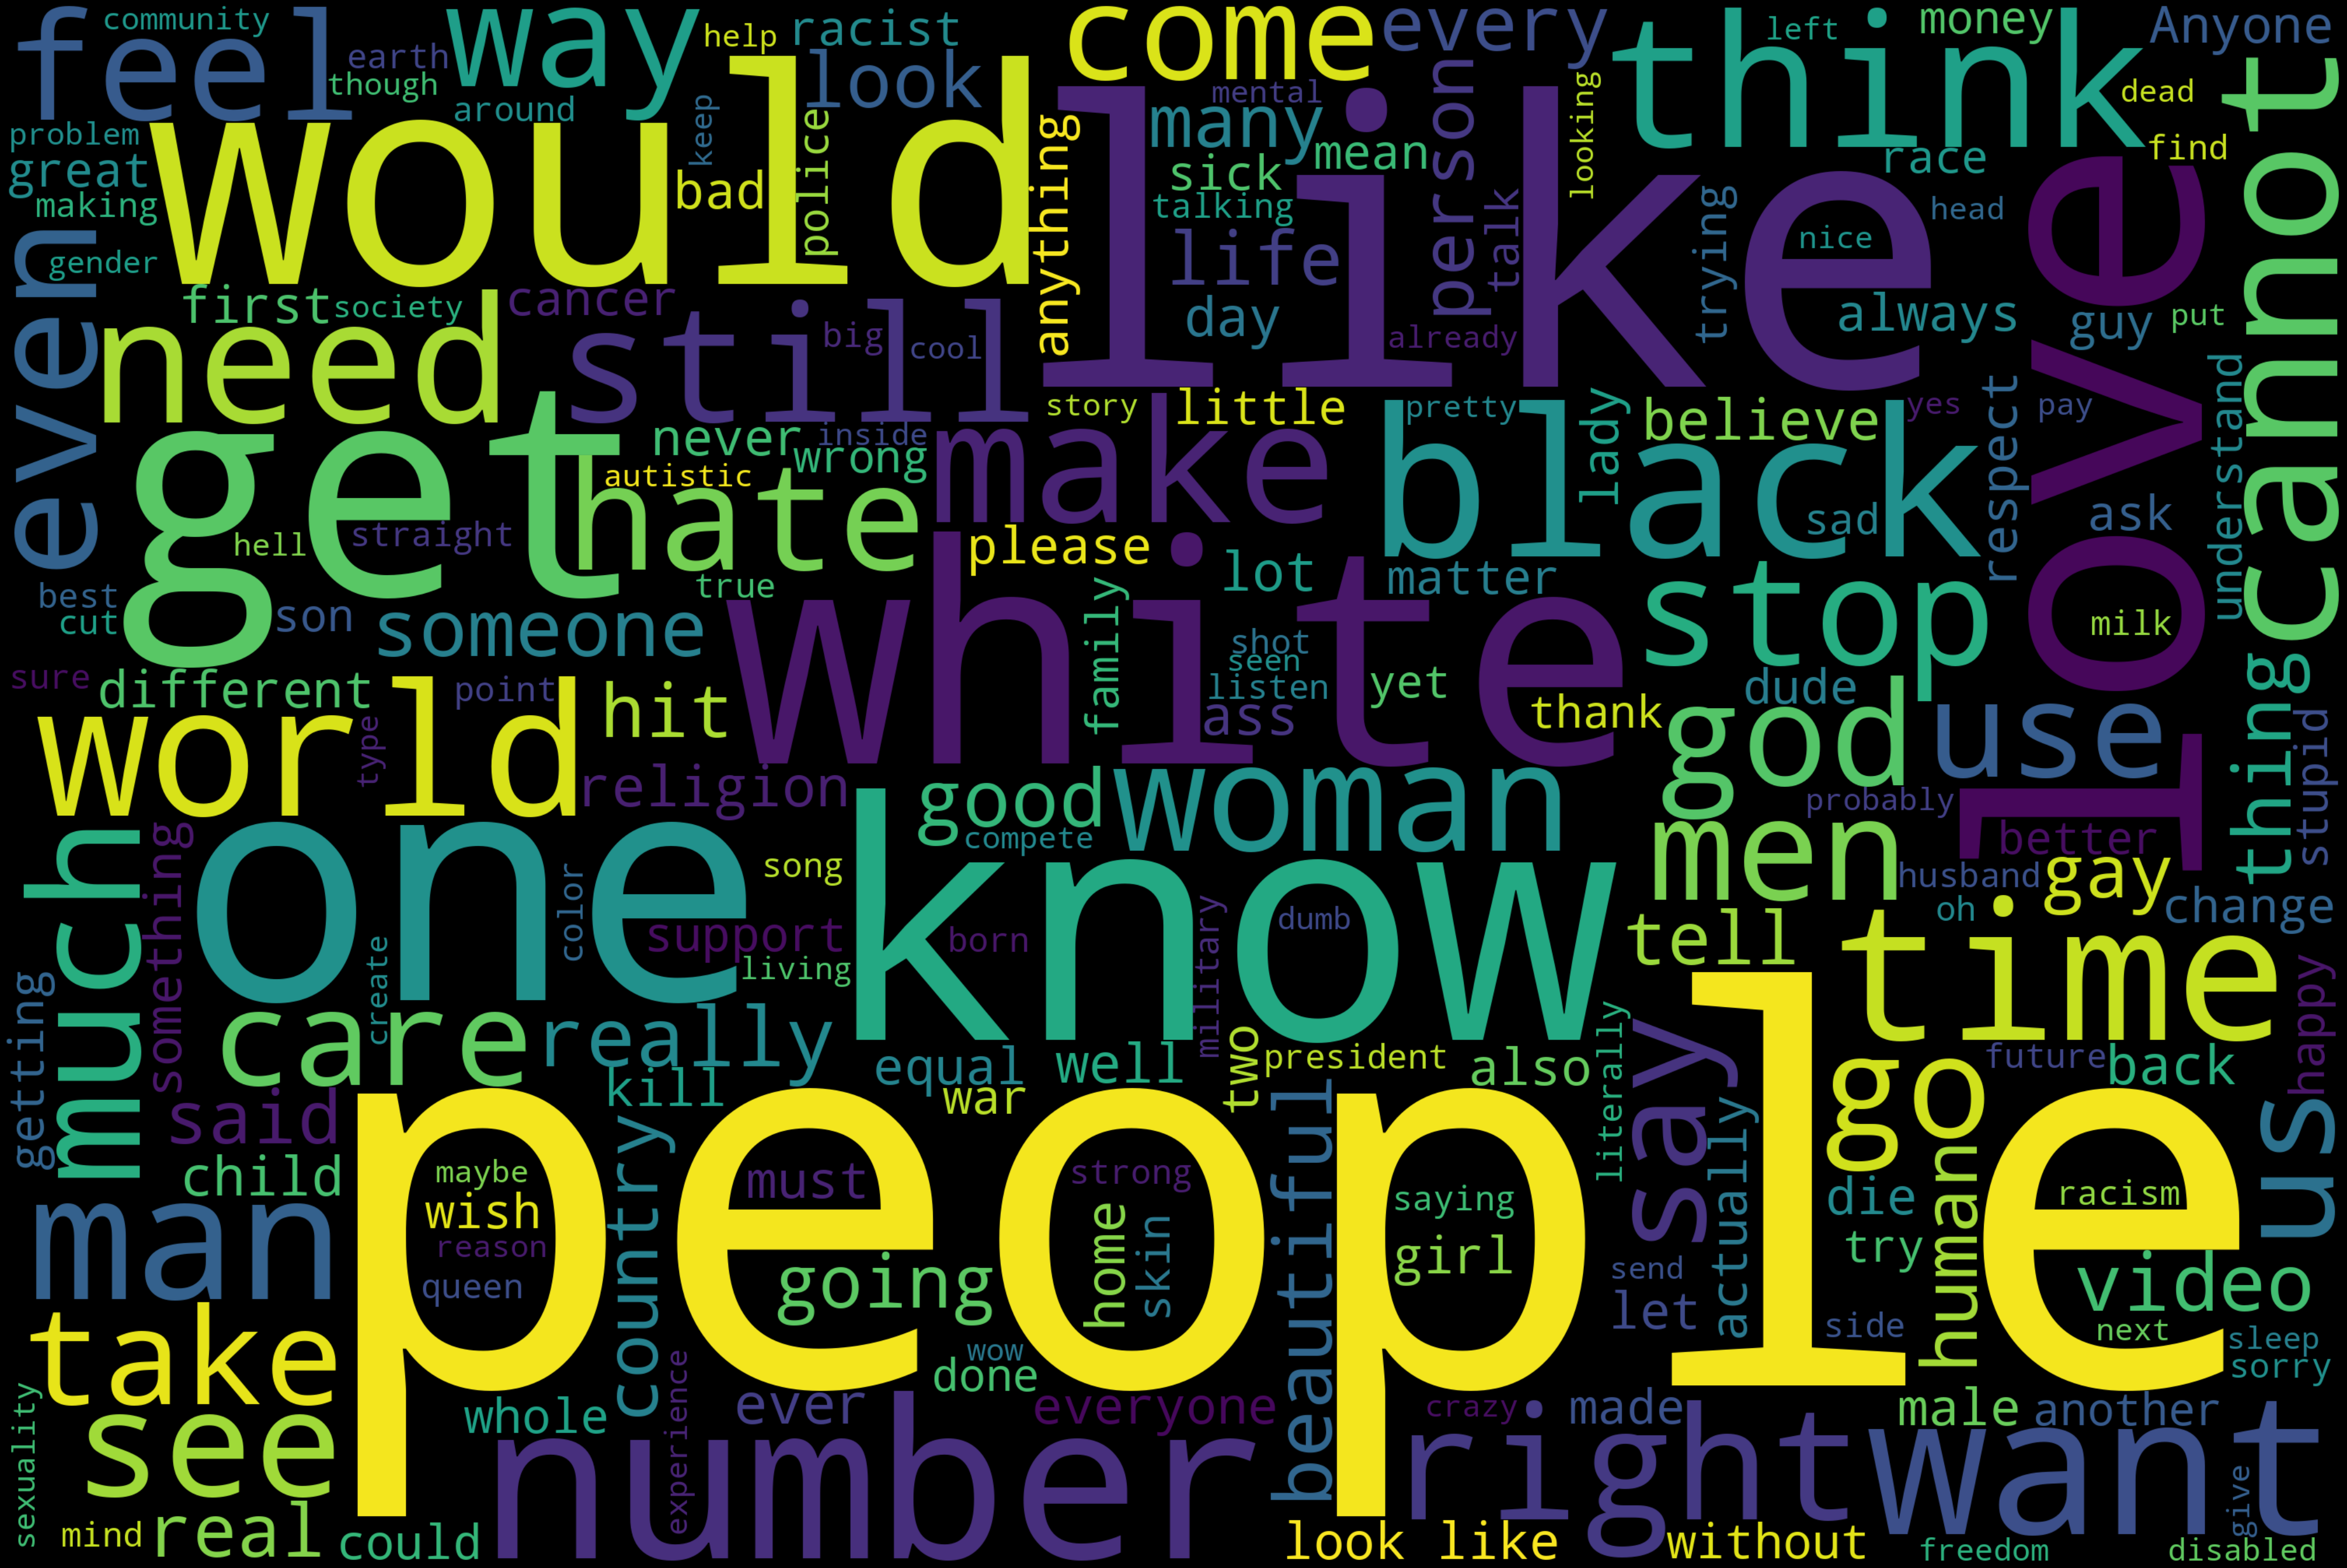

In [90]:
visualizer.generate_wordcloud_non_hate()

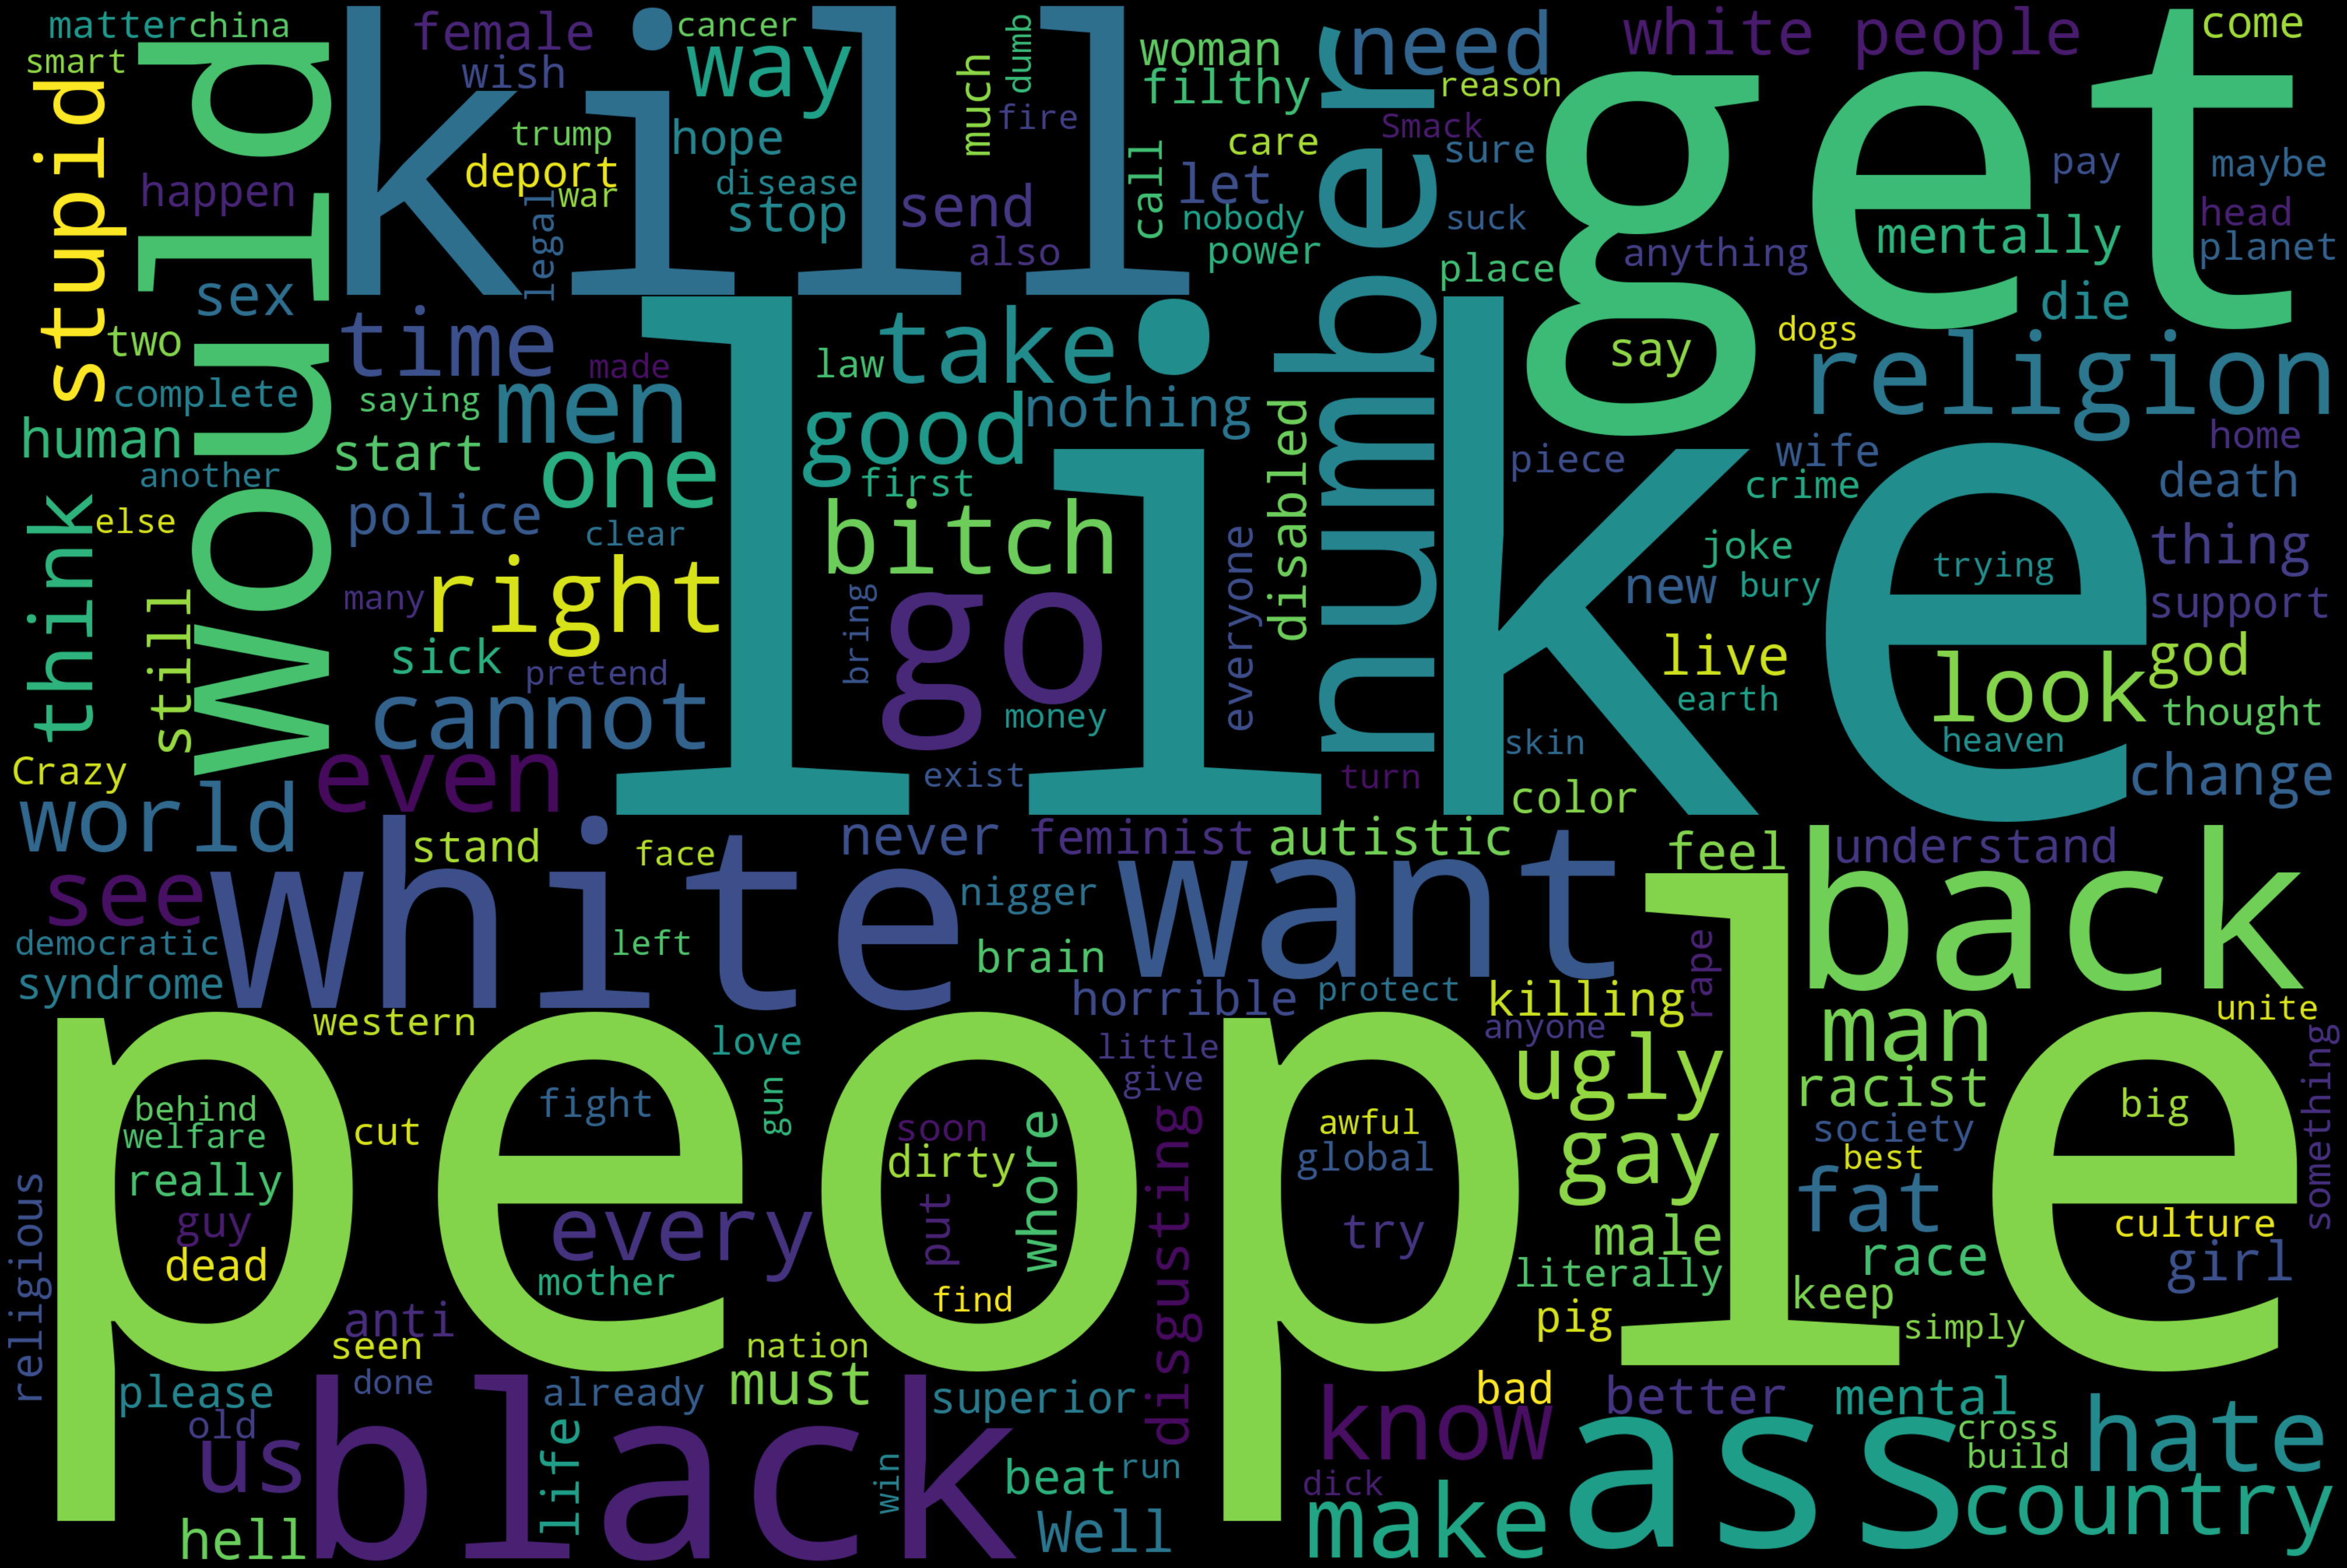

In [91]:
visualizer.generate_wordcloud_hate()

In [92]:
visualizer.visualize_polarity_distribution()

In [93]:
visualizer.visualize_review_length_distribution()

In [94]:
visualizer.visualize_word_count_distribution()